In [1]:
from datetime import datetime

# print date as date accessed
date_accessed = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Date accessed: {date_accessed}")

Date accessed: 2024-10-12 20:04:39


In [2]:
import xarray as xr
import dask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, glob, re, time, math, calendar

# import custom functions
sys.path.append('/')
from libraries import *

In [4]:
# we would like to make sure that the reference height levels cover the profiler levels and NOW23 levels, including the 0 m level.
profilers_levels = np.array([10] + list(range(100, 501, 25)))
NOW23_levels = np.array([10] + list(range(20, 301, 20)) + [400, 500])
# combine the two arrays and remove duplicates
ref_H = np.unique(np.concatenate((np.array([0]),profilers_levels, NOW23_levels)))
profilers_levels, NOW23_levels, ref_H

(array([ 10, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375,
        400, 425, 450, 475, 500]),
 array([ 10,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 400, 500]),
 array([  0,  10,  20,  40,  60,  80, 100, 120, 125, 140, 150, 160, 175,
        180, 200, 220, 225, 240, 250, 260, 275, 280, 300, 325, 350, 375,
        400, 425, 450, 475, 500]))

# Profiler data

In [3]:
station_id = 'PROF_OWEG'
ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/{station_id}.nc')
data = ds.wind_speed.sel(range=slice(10,500))
data

<xarray.DataArray 'wind_speed' (range: 18, time: 52560)> Size: 4MB
[946080 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 420kB 2018-01-02 ... 2024-01-01
  * range    (range) int64 144B 10 100 125 150 175 200 ... 400 425 450 475 500
    station  <U9 36B ...

- The idea is, not all instances have wind speed values at all vertical levels. 
- During some instances, wind speed at all the vertical levels might be nans. 
- During some instances, wind speed at some vertical levels might be nans, while the non-missing are insufficient for a complete profile building. 
- During some instances, wind speed at some vertical levels might be nans, while the non-missing are sufficient for a complete profile building. 
- In such scenarios, we need provide the vertical levels having non-missing values in computing the Chebyshev coefficients. 

## Checking for full non-missing instances

<xarray.DataArray 'wind_speed' ()> Size: 8B
np.int64(29581)
Coordinates:
    station  <U9 36B ... non-missing instances
Bias: 0.0000
MAE: 0.0855
RMSE: 0.1115
Rmax: 0.2815


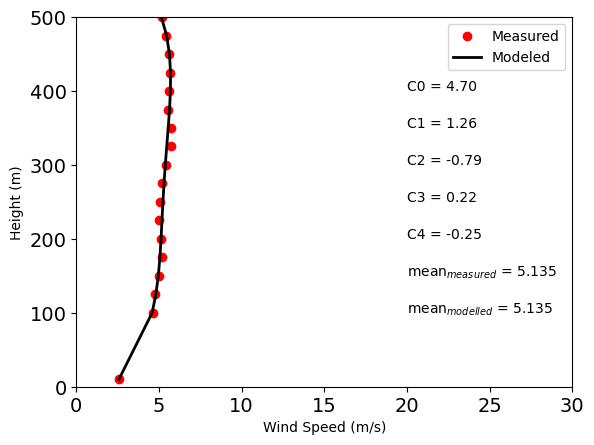

In [14]:
# find data only with non-missing instances
station_id = 'PROF_OWEG'
ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/{station_id}.nc')
data = ds.wind_speed.sel(range=slice(10,500))

non_missing_mask = data.notnull().all(dim='range')
non_missing_data = data.where(non_missing_mask, drop=True)
print(non_missing_mask.sum(dim='time'), 'non-missing instances')

# randomly select one profile for visualization
np.random.seed(14000)
time_idx = np.random.choice(non_missing_data.time)
M = non_missing_data.sel(time=time_idx)
Z = M.range.values

poly_order = 4
CPtype = 1
Coeff = Chebyshev_Coeff(Z, M.values,poly_order=poly_order, CPtype=CPtype, ref_H=ref_H)
Mp = WindProfile(Z,Coeff, poly_order=poly_order,CPtype=CPtype,ref_H=ref_H)
# Calculate statistics
Bias = np.mean(M - Mp)
MAE = np.mean(np.abs(M - Mp))
RMSE = np.sqrt(np.mean((M - Mp)**2))
Rmax = np.max(np.abs(M - Mp))

# Print the statistics
print(f'Bias: {Bias:.4f}')
print(f'MAE: {MAE:.4f}')
print(f'RMSE: {RMSE:.4f}')
print(f'Rmax: {Rmax:.4f}')

# Create Coeff_tot array
Coeff_tot = np.zeros(10)
Coeff_tot[:len(Coeff)] = Coeff

# Plot and save the figure
fig, ax = plt.subplots()
ax.plot(M, Z, 'or', markerfacecolor='r')
ax.plot(Mp, Z, '-k', linewidth=2)
ax.set(xlabel='Wind Speed (m/s)', ylabel='Height (m)')
ax.set_xlim([0, 30])
ax.set_ylim([0, 500])
ax.tick_params(labelsize=14)
ax.legend(['Measured', 'Modeled'])
plt.text(20, 400, f'C0 = {Coeff_tot[0]:.2f}')
plt.text(20, 350, f'C1 = {Coeff_tot[1]:.2f}')
plt.text(20, 300, f'C2 = {Coeff_tot[2]:.2f}')
plt.text(20, 250, f'C3 = {Coeff_tot[3]:.2f}')
plt.text(20, 200, f'C4 = {Coeff_tot[4]:.2f}')
plt.text(20, 150, fr'mean$_{{measured}}$ = {M.mean():.3f}')
plt.text(20, 100, fr'mean$_{{modelled}}$ = {Mp.mean():.3f}')
plt.savefig(f'data/Figures/chebyshev_fit_with_p{poly_order}_no-missing.png')

- It seems, the C0 values is not matching with the mean of the wind profile. 
- To examine where the problem is, we compared our script with python function from numpy.polynomial.chebyshev import chebfit

### Validating our script with numpy inbuilt function for chebyshev

In [15]:
from numpy.polynomial.chebyshev import chebfit
CPtype = 1
Hn = normalize(Z, ref_H)
print('Reference height: ', ref_H)
print('Height: ', Z)
print('Normalized height: ', Hn)
for poly_order in range(1, 11):
    Coeff1 = Chebyshev_Coeff(Z, M.values,poly_order=poly_order, CPtype=CPtype, ref_H=ref_H)
    Coeff2 = chebfit(Hn, M, poly_order)    
    print(f'CPtype: {CPtype}, \t Poly order: {poly_order}, \t C0 from my script: {Coeff1[0]}, \t C0 from numpy function: {Coeff2[0]},\t mean wind: {M.mean().values}')

Reference height:  [  0  10  20  40  60  80 100 120 125 140 150 160 175 180 200 220 225 240
 250 260 275 280 300 325 350 375 400 425 450 475 500]
Height:  [ 10 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500]
Normalized height:  [-0.96 -0.6  -0.5  -0.4  -0.3  -0.2  -0.1   0.    0.1   0.2   0.3   0.4
  0.5   0.6   0.7   0.8   0.9   1.  ]
CPtype: 1, 	 Poly order: 1, 	 C0 from my script: 5.00672907185047, 	 C0 from numpy function: 5.0067290718504704,	 mean wind: 5.134591579437256
CPtype: 1, 	 Poly order: 2, 	 C0 from my script: 4.722080496279246, 	 C0 from numpy function: 4.722080496279249,	 mean wind: 5.134591579437256
CPtype: 1, 	 Poly order: 3, 	 C0 from my script: 4.7030474418904875, 	 C0 from numpy function: 4.7030474418904875,	 mean wind: 5.134591579437256
CPtype: 1, 	 Poly order: 4, 	 C0 from my script: 4.699786384662939, 	 C0 from numpy function: 4.699786384662942,	 mean wind: 5.134591579437256
CPtype: 1, 	 Poly order: 5, 	 C0 from my script: 4.711025846050129,

## Checking for conditional non-missing values

In [16]:
import numpy as np
import xarray as xr

# Define the station ID and open the dataset
station_id = 'PROF_OWEG'
ds = xr.open_dataset(f'data/NYSM_standard_and_profiler_combined_wind_speed/{station_id}.nc')
data = ds.wind_speed.sel(range=slice(10, 500))

# Define the number of required non-missing points for intermediate range
intermediate_non_missing_points = 4

# Masks to ensure non-missing points in each segment
first_segment_mask = data.sel(range=slice(100, 200)).notnull().sum(dim='range') >= 2
last_segment_mask = data.sel(range=slice(400, 500)).notnull().sum(dim='range') >= 2
intermediate_segment_mask = data.sel(range=slice(225, 375)).notnull().sum(dim='range') >= intermediate_non_missing_points

# Combine masks to select data meeting all conditions
conditional_non_missing_mask = first_segment_mask & last_segment_mask & intermediate_segment_mask
filtered_data = data.where(conditional_non_missing_mask, drop=True)

# Within filtered data, identify all non-missing and some-missing instances
all_non_missing_mask = filtered_data.notnull().all(dim='range')
all_non_missing_data = filtered_data.where(all_non_missing_mask, drop=True)
some_missing_mask = filtered_data.isnull().any(dim='range')
some_missing_data = filtered_data.where(some_missing_mask, drop=True)

# Verifying if the data satisfies the conditions
print("Total instances after conditional filtering:", filtered_data.time.size)
print("Total non-missing instances after conditional filtering:", all_non_missing_data.time.size)
print("Total some missing instances after conditional filtering:", some_missing_data.time.size)

# randomly select one profile for visualization
np.random.seed(14000)
time_idx = np.random.choice(some_missing_data.time)
M = some_missing_data.sel(time=time_idx)
Z = M.range.values

Total instances after conditional filtering: 31605
Total non-missing instances after conditional filtering: 29581
Total some missing instances after conditional filtering: 2024


Bias: -0.0000
MAE: 0.1413
RMSE: 0.1791
Rmax: 0.3507


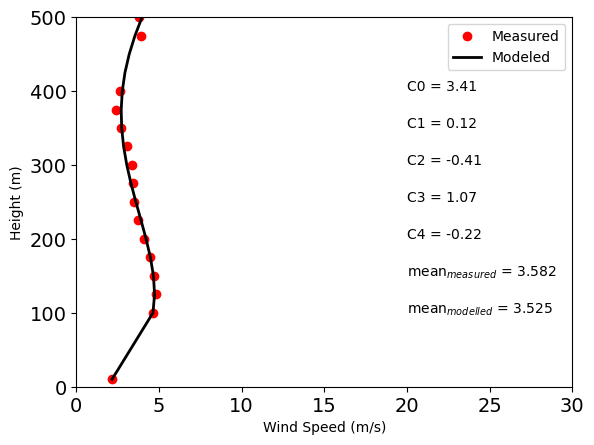

In [17]:
poly_order = 4
CPtype = 1
Coeff = Chebyshev_Coeff(Z, M.values,poly_order=poly_order, CPtype=CPtype, ref_H=ref_H)
Mp = WindProfile(Z,Coeff, poly_order=poly_order,CPtype=CPtype,ref_H=ref_H)
# Calculate statistics
Bias = np.mean(M - Mp)
MAE = np.mean(np.abs(M - Mp))
RMSE = np.sqrt(np.mean((M - Mp)**2))
Rmax = np.max(np.abs(M - Mp))

# Print the statistics
print(f'Bias: {Bias:.4f}')
print(f'MAE: {MAE:.4f}')
print(f'RMSE: {RMSE:.4f}')
print(f'Rmax: {Rmax:.4f}')

# Create Coeff_tot array
Coeff_tot = np.zeros(10)
Coeff_tot[:len(Coeff)] = Coeff

# Plot and save the figure
fig, ax = plt.subplots()
ax.plot(M, Z, 'or', markerfacecolor='r')
ax.plot(Mp, Z, '-k', linewidth=2)
ax.set(xlabel='Wind Speed (m/s)', ylabel='Height (m)')
ax.set_xlim([0, 30])
ax.set_ylim([0, 500])
ax.tick_params(labelsize=14)
ax.legend(['Measured', 'Modeled'])
plt.text(20, 400, f'C0 = {Coeff_tot[0]:.2f}')
plt.text(20, 350, f'C1 = {Coeff_tot[1]:.2f}')
plt.text(20, 300, f'C2 = {Coeff_tot[2]:.2f}')
plt.text(20, 250, f'C3 = {Coeff_tot[3]:.2f}')
plt.text(20, 200, f'C4 = {Coeff_tot[4]:.2f}')
plt.text(20, 150, fr'mean$_{{measured}}$ = {M.mean():.3f}')
plt.text(20, 100, fr'mean$_{{modelled}}$ = {Mp.mean():.3f}')
plt.savefig(f'data/Figures/chebyshev_fit_with_p{poly_order}_conditional-missing.png')

### Saving Chebyshev coefficients to netcdf file for one station

In [84]:
poly_order = 4
CPtype = 1

# Number of observations, time steps, and height levels
n_height,n_time = filtered_data.shape

# Initialize Coeff array
Coeff = np.zeros((n_time, poly_order+1))
# Iterate over time steps
U = filtered_data.values
stime = time.time()
for t in range(n_time):
    Coeff[t, :] = Chebyshev_Coeff(Z, U[:,t],poly_order=poly_order, CPtype=CPtype, ref_H=ref_H)
etime = time.time()
print(f'Time elapsed: {etime-stime}s')
coeff_da = xr.DataArray(Coeff, dims=['time', 'coeff'], coords={'time': filtered_data.time, 'coeff': np.arange(poly_order+1)},name='Chebyshev_Coefficients')

# Save the coefficients to a netCDF file
output_dir = f'data/Profiler_Chebyshev_Coefficients'
os.makedirs(output_dir, exist_ok=True)
coeff_da.to_netcdf(f'{output_dir}/{station_id}.nc')

Time elapsed: 3.97575306892395s


# NOW23 data
- Defnitely will not have any missing data, since it is from simulations. 

In [5]:
# Define the height levels and ensure the output directory exists
station_id = 'PROF_OWEG'
dfs = []
for year in range(2000,2021):
    df = pd.read_csv(f'data/NOW23/{station_id}/{year}.csv',index_col=0)
    df.index = pd.to_datetime(df.index)
    dfs.append(df)
combined_df = pd.concat(dfs,axis=0)

Bias: 0.0000
MAE: 0.1196
RMSE: 0.1393
Rmax: 0.2385


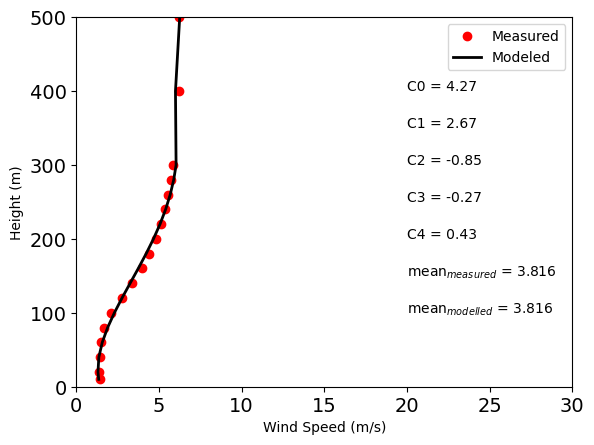

In [6]:
# randomly select one profile for visualization
np.random.seed(14000)
time_idx = np.random.choice(combined_df.index)
# select the data for the selected time
M = combined_df.loc[time_idx]
Z = np.array([10] + list(range(20, 301, 20)) + [400, 500])

poly_order = 4
CPtype = 1
Coeff = Chebyshev_Coeff(Z, M.values,poly_order=poly_order, CPtype=CPtype, ref_H=ref_H)
Mp = WindProfile(Z,Coeff, poly_order=poly_order,CPtype=CPtype,ref_H=ref_H)
# Calculate statistics
Bias = np.mean(M - Mp)
MAE = np.mean(np.abs(M - Mp))
RMSE = np.sqrt(np.mean((M - Mp)**2))
Rmax = np.max(np.abs(M - Mp))

# Print the statistics
print(f'Bias: {Bias:.4f}')
print(f'MAE: {MAE:.4f}')
print(f'RMSE: {RMSE:.4f}')
print(f'Rmax: {Rmax:.4f}')

# Create Coeff_tot array
Coeff_tot = np.zeros(10)
Coeff_tot[:len(Coeff)] = Coeff

# Plot and save the figure
fig, ax = plt.subplots()
ax.plot(M, Z, 'or', markerfacecolor='r')
ax.plot(Mp, Z, '-k', linewidth=2)
ax.set(xlabel='Wind Speed (m/s)', ylabel='Height (m)')
ax.set_xlim([0, 30])
ax.set_ylim([0, 500])
ax.tick_params(labelsize=14)
ax.legend(['Measured', 'Modeled'])
plt.text(20, 400, f'C0 = {Coeff_tot[0]:.2f}')
plt.text(20, 350, f'C1 = {Coeff_tot[1]:.2f}')
plt.text(20, 300, f'C2 = {Coeff_tot[2]:.2f}')
plt.text(20, 250, f'C3 = {Coeff_tot[3]:.2f}')
plt.text(20, 200, f'C4 = {Coeff_tot[4]:.2f}')
plt.text(20, 150, fr'mean$_{{measured}}$ = {M.mean():.3f}')
plt.text(20, 100, fr'mean$_{{modelled}}$ = {Mp.mean():.3f}')
plt.savefig(f'data/Figures/NOW23_chebyshev_fit_with_p{poly_order}_conditional-missing.png')

### Saving Chebyshev coefficients to netcdf for one station

In [ ]:
poly_order = 4
CPtype = 1

# Number of observations, time steps, and height levels
n_time, n_height = combined_df.shape

# Initialize Coeff array
Coeff = np.zeros((n_time, poly_order+1))
# Iterate over time steps
U = combined_df.values
stime = time.time()
for t in range(n_time):
    Coeff[t, :] = Chebyshev_Coeff(Z, U[t,:],poly_order=poly_order, CPtype=CPtype, ref_H=ref_H)
etime = time.time()
print(f'Time elapsed: {etime-stime}s')

In [14]:
coeff_da = xr.DataArray(Coeff, dims=['time', 'coeff'], coords={'time': combined_df.index.values, 'coeff': np.arange(poly_order+1)},name='Chebyshev_Coefficients')

# Save the coefficients to a netCDF file
output_dir = f'data/NOW23_Chebyshev_Coefficients'
os.makedirs(output_dir, exist_ok=True)
coeff_da.to_netcdf(f'{output_dir}/{station_id}.nc')